In [20]:
import pandas as pd
import numpy as np
%matplotlib inline
from sklearn.metrics import accuracy_score
import quandl
import matplotlib.pyplot as plt
import os
#becasue i use pylab with Dark theme
plt.style.use(['dark_background'])

import pandas_datareader.data as web
from sklearn.linear_model import LogisticRegression


We will try to predict if the Closing price will be higher than the opening price and then
We will buy the stock at the opening price and sell it at the closing price only when we predict an increase in price 
    

In [21]:
def get_data( 
    symbol = 'AAPL'           ,
    source = 'morningstar'    ,
    start_date = "2011-01-01" ,
    end_date = "2018-03-01"   ):
    #"""Download a file if not present"""



    global filename 
    filename=symbol+'_'+start_date+'_'+end_date+'csv'

    if not os.path.exists(filename):
        print 'Downloading Data'
        aapl = web.DataReader(symbol, source, start_date, end_date)
        aapl.index = aapl.index.droplevel(level=0)
        aapl.to_csv(filename)
    
    else:
        
        aapl=pd.read_csv(symbol+'_'+start_date+'_'+end_date+'csv')
        
    return aapl

aapl=get_data()    
print aapl.head(),'\n'
print aapl.dtypes,'\n'


print 'Checkinf for N/As \n',(aapl.isnull()).sum()

         Date    Close     High      Low     Open     Volume
0  2011-01-03  47.0814  47.1800  46.4052  46.5571  111280407
1  2011-01-04  47.3271  47.5000  46.8786  47.5000   77337001
2  2011-01-05  47.7143  47.7629  47.0714  47.0786   63879193
3  2011-01-06  47.6757  47.8929  47.5571  47.8571   75106626
4  2011-01-07  48.0171  48.0500  47.4143  47.7314   77982212 

Date       object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object 

Checkinf for N/As 
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


In [22]:
def cleaning(aapl):
    aapl['Date']=pd.to_datetime(aapl['Date'])
    aapl.set_index(aapl['Date'],inplace=True,drop=True)

    aapl.dropna(axis=0,inplace=True)
    
    return aapl

aapl=cleaning(aapl)

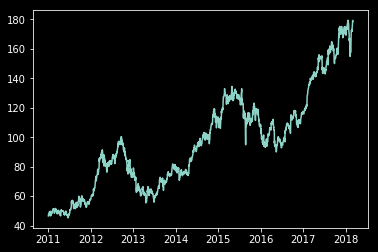

In [23]:
plt.plot(aapl['Open'])

In [24]:
#getting the closing price for the previous 10 days
aapl['Close-1']=aapl['Close'].shift(1)
aapl['Close-2']=aapl['Close'].shift(2)
aapl['Close-3']=aapl['Close'].shift(3)
aapl['Close-4']=aapl['Close'].shift(4)
aapl['Close-5']=aapl['Close'].shift(5)
aapl['Close-6']=aapl['Close'].shift(6)
aapl['Close-7']=aapl['Close'].shift(7)
aapl['Close-8']=aapl['Close'].shift(8)
aapl['Close-9']=aapl['Close'].shift(9)
aapl['Close-10']=aapl['Close'].shift(10)

#getting moving averages and std
aapl['MA50']=aapl['Close'].rolling(window=50).mean()
aapl['MA200']=aapl['Close'].rolling(window=200).mean()
aapl['std50']=aapl['Close'].rolling(window=50).std()
aapl['std200']=aapl['Close'].rolling(window=200).std()

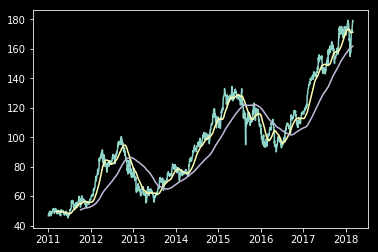

In [25]:
plt.plot(aapl[['Open','MA50','MA200']])

In [26]:
#Var is the price Variation in a day in % of the Opening price
aapl['Var']=(aapl['Close']-aapl['Open'])*100./aapl['Open']/100.

#get the Variation for the last 10 days
aapl['Var-1']=aapl['Var'].shift(1)
aapl['Var-2']=aapl['Var'].shift(2)
aapl['Var-3']=aapl['Var'].shift(3)
aapl['Var-4']=aapl['Var'].shift(4)
aapl['Var-5']=aapl['Var'].shift(5)
aapl['Var-6']=aapl['Var'].shift(6)
aapl['Var-7']=aapl['Var'].shift(7)
aapl['Var-8']=aapl['Var'].shift(8)
aapl['Var-9']=aapl['Var'].shift(9)
aapl['Var-10']=aapl['Var'].shift(10)

#Creating the boolean value we will try to forecast : will the price variation be positive or negative?
aapl['Var bool']=0
aapl.loc[aapl['Var']>=0.0000,'Var bool']=1

In [27]:
#Dropping N/A due to the shifts
aapl.dropna(axis=0,inplace=True)

#We are separating the testing and training samples. the limit between the two is date lime
datelim='2017-10-01'

Params=['Close-1', u'Close-2',u'Close-3', u'Close-4', u'Close-5', u'Close-6', u'Close-7', u'Close-8',
       u'Close-9', u'Close-10', u'MA50', u'MA200','Var-1', u'Var-2', u'Var-3','Var-4', u'Var-5', u'Var-6',
   u'Var-7', u'Var-8', u'Var-9', u'Var-10','std50','std200']

Target='Var bool'

Xtrain=aapl.loc[aapl.index<datelim,Params]
Xtest=aapl.loc[aapl.index>=datelim,Params]

ytrain=aapl.loc[aapl.index<datelim,Target]
ytest =aapl.loc[aapl.index>=datelim,Target]

In [28]:
def LogisticReg(aapl,C=0.001):   

    #Training the logistic regresison on the training set
    logreg = LogisticRegression(C=C,max_iter=10000000)
    logreg.fit(Xtrain, ytrain)

    #print logreg.coef_
    #print logreg.intercept_

    print 'score',np.around(logreg.score(Xtest, ytest)*100,decimals=2),'%'

    return logreg

logreg=LogisticReg(aapl,C=0.001)

score 55.05 %


In [29]:
#get prediction
Xtest_pred=logreg.predict(Xtest)


df=Xtest
df['Var bool pred']   =Xtest_pred #predicted variation boolean by the model
df['Var bool actual'] =ytest      #actual 
df['Var']= aapl.loc[aapl.index>=datelim,'Var']
#df['Stock volume']=100/df.loc['2017-10-02','Open']



Return 14.141932276957956 %
Average aapl return 0.0829539684279 %
value increase [12.10857143] %


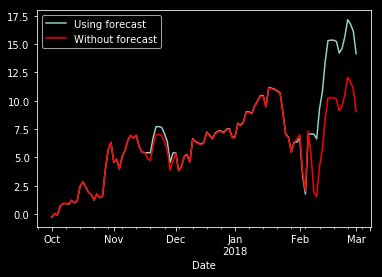

In [30]:
df['Revenue']=df['Var']*df['Var bool pred']*100 #We buy at the opening price and seel at the closing price only when we predict an increase in price (Var bool pred =1)
       
        
df['Gain']=df['Revenue'].cumsum()
df['Gain'].plot(label='Using forecast')
(df['Var'].cumsum()*100).plot(c='r',label='Without forecast')
plt.legend()
print 'Return',df['Revenue'].sum(),'%'    
print 'Average aapl return',aapl.loc[aapl.index>=datelim,'Var'].mean()*100 ,'%'
print  'value increase',(aapl.loc[aapl.index=='2018-03-01','Close'].values-aapl.loc[aapl.index=='2017-10-02','Close'].values)/aapl.loc[aapl.index=='2018-03-01','Close'].values*100,'%'

In [31]:
(df['Revenue'].mean()/df['Revenue'].std()) * np.sqrt(len(df))

1.2659363636195582